### Visualization Performance


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
from matplotlib import pyplot as plt
import matplotlib.dates as mdate
import matplotlib.dates as mdates
import glob
import os
from collections import Counter
import tensorflow as tf

In [4]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [2]:
# get last weight
newest = False

test_weight = {
    'transformer': '20220922-003626_e500_s30.h5',
    'conv1d': '20220922-010800_e500_s30.h5',
    'conv2d': '20220922-010843_e500_s30.h5',
    # 'dnn': '202209112327_dataset_2015_2019_dnn-ep002',
    'lstm': '20220922-011359_e500_s30.h5'
 }
# test data
stock = 'TWII_test.csv'

if newest:
    for model in test_weight.keys():
        target_weight_list = [x.replace('.h5','') for x in glob.glob(os.path.join('weights',model,'*.h5')) if stock in x]
        test_weight[model] = target_weight_list[-1].split('\\')[2]

# window length
# slide = 30

data = pd.read_csv(f'data/{stock}')
model_metric = {}
test_weight

{'transformer': '20220922-003626_e500_s30.h5',
 'conv1d': '20220922-010800_e500_s30.h5',
 'conv2d': '20220922-010843_e500_s30.h5',
 'lstm': '20220922-011359_e500_s30.h5'}

### Predict Price

In [3]:
%%time

X, y = label(df)
X_scaler, y_scaler = scaler(X, y, config, args)
X_scaler, y_scaler = training_window(X_scaler, y_scaler , config)
    
for model, weight in test_weight.item(): 
    weight = os.path.join(f'model/{model}/{weight}')
    model_ = tf.keras.models.load_model(weight)
    y_pred = model_.predict(X_scaler)
    y_inverse = inverse_predict(y_pred, config)
    # print('y_pred',y_pred.shape)
    # print('y_inverse',y_inverse.shape)
    mse = mean_squared_error(y[int(config['MODEL']['slide']):], y_inverse, squared=False)   



test_value

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             576       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 128)            16512     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 batch_normalization (BatchN  (None, 5, 128)           512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0

{'conv1d': Counter({52: 133, 113: 107, 37: 2}),
 'dnn': Counter({83: 242}),
 'lstm': Counter({108: 242})}

dataset_2021_2021 data


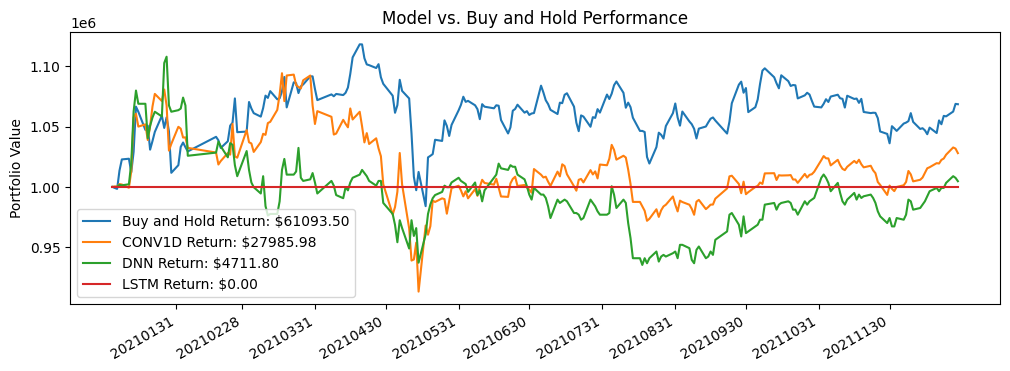

In [4]:

def plot_all_model(stock_name, model_metric, env):
    print(stock_name,'data')
    """combined plots of plot_portfolio_transaction_history and plot_portfolio_performance_comparison"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())

    dates, buy_and_hold_portfolio_values, buy_and_hold_return = buy_and_hold_benchmark(stock_name, env.init_invest, env.n_stock)
    ax.set_title(f'Model vs. Buy and Hold Performance')
    dates = [datetime.strptime(d, '%Y%m%d').date() for d in dates]
    ###
    dates = dates[:-1]
    buy_and_hold_portfolio_values = buy_and_hold_portfolio_values[:-1]
    # print(f'dates:     {len(dates)} \ndaily value:{len(daily_portfolio_value)}\nBH value:{len(buy_and_hold_portfolio_values)}')
    ax.plot(dates, buy_and_hold_portfolio_values, label=f'Buy and Hold Return: ${buy_and_hold_return:.2f}')
    ###
    for model, portfolio in model_metric.items():
        agent_return = portfolio[-1] - env.init_invest
        ax.plot(dates, portfolio, label=f'{model.upper()} Return: ${agent_return:.2f}')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))
    # plt.xticks(pd.date_range('2018-1-02', '2019-08-22', freq='1m'))
    plt.xticks(pd.date_range(dates[0],dates[-1],freq='1m'))
    ax.legend()
    plt.gcf().autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

plot_all_model(stock_name, model_metric, env)    

In [5]:
# agent.save('test_with.h5')
# agent.save('test_without.h5')

In [6]:
import random
a = ['a','b','c']

random.sample(a,1)
a[-1:]

['c']